# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
# import for the project
import pandas as pd
import requests 
from PIL import Image 
from io import BytesIO
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reading the 'twitter-archive-enhanced.csv'
# Dataset 1
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Using the '.sample()' to display three (3) sample outcome.
df_twitter_archive.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1911,674410619106390016,NaN,NaN,2015-12-09 02:09:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lenny. He wants to be a sprinkler. 10/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674410619...,10,10,Lenny,None,None,None,None
1283,708711088997666817,NaN,NaN,2016-03-12 17:47:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Smokey. He really likes tennis balls. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708711088...,11,10,Smokey,None,None,None,None
1164,723179728551723008,NaN,NaN,2016-04-21 16:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jangle. She's addicted to broccoli. It...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/723179728...,8,10,Jangle,None,None,None,None


In [4]:
# patients[patients['address'].isnull()]
#df_twitter_archive[df_twitter_archive['name'] == 'a']

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [5]:
# Reading in the 'image-predictions.tsv' Tab-Separated-Value file.
# Dataset 2.

df_image_prediction = pd.read_csv('image-predictions.tsv', sep='\t')

In [6]:
# Displaying with the .head()
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
# Using '.tail()' to display the last five (5) records of the dataset.
df_image_prediction.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

#Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
#These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

#NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
#df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
#change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
#NOTE TO REVIEWER: this student had mobile verification issues so the following
#Twitter API code was sent to this student from a Udacity instructor
#Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

#Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
#Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)


In [8]:
# Reading in the 'tweet-json.txt' 
# Dataset -3.
# Used the provided Tweet from the classroom

with open('tweet-json.txt','r') as file:
    lines = file.readlines()
tweets = []
for line in lines:
    tweets.append(json.loads(line))

df_tweets = pd.DataFrame(tweets)

In [9]:
# Using the '.head()' to display the first five records from the dataset. 
df_tweets.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Two types of Assessment are used:
>* (1). Viasual assessment:
>* (2). Programmatic Assessment: Pandas functions and methods are used to assess the data.

#### Dataset one (1) displayed for Visual Assessment

In [10]:
# Dataset one (1)
# This dataset is displayed for visual assessment
df_twitter_archive 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


#### Dataset one (1) displayed for Programmatic Assessment

In [11]:
# Displayed the first five rows of the dataset
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
# Displayed the last five rows of the dataset
df_twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [13]:
# Dataset programmatic Assessment
# Give the general overveiw of the dataset, it's rows size, columns and the data types 
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [14]:
# Using the describe function.
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [15]:
# Checking for the maximum value in the rating_numerator column.
df_twitter_archive['rating_numerator'].max()

1776

In [16]:
df_twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [17]:
# Checking for the minimum value in the rating_numerator column.
df_twitter_archive['rating_numerator'].min()

0

In [18]:
# Checking for the maximum value in the rating_denominator column.
df_twitter_archive['rating_denominator'].max()

170

In [19]:
# Checking for the minimum value in the rating_denominator column.
df_twitter_archive['rating_denominator'].min()

0

In [20]:
sum(df_twitter_archive['rating_denominator'] == 0)

1

In [21]:
df_twitter_archive.source.duplicated().value_counts()
# df_twitter_archive[df_twitter_archive.source.duplicated()]

True     2352
False       4
Name: source, dtype: int64

#### Dataset two (2) displayed for Visual Assessment

In [22]:
# Dataset two (2) 
df_image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [23]:
list(df_image_prediction)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

#### Dataset two (2) displayed for Programmatic Assessment

In [24]:
# Dataset two 
# Displayed the first five rows of the dataset
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [25]:
# Displayed the last five rows of the dataset
df_image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [26]:
# Give the general overveiw of the dataset, it's rows size, columns and the data types 
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [27]:
# Using the describe() function to summarizes the numerical columns
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [28]:
# Counting the category data
df_image_prediction['p1_dog'].value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [29]:
# Counting the category data
df_image_prediction['p2_dog'].value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [30]:
# Counting the category data
df_image_prediction['p3_dog'].value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

#### Dataset three (3) displayed for Visual Assessment

In [31]:
# Dataset three (3) 
df_tweets

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,None,None,Sat Jul 29 00:08:17 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,None,...,False,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,None,None,Fri Jul 28 16:27:12 +0000 2017,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,None,...,False,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,None,None,Fri Jul 28 00:22:40 +0000 2017,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,None,...,False,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,None,None,Thu Jul 27 16:25:51 +0000 2017,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,None,...,False,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,None,None,Wed Jul 26 15:59:51 +0000 2017,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,None,...,False,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835'

#### Dataset three (3) displayed for Programmatic Assessment

In [32]:
# Displayed the first five rows of the dataset
df_tweets.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,None,...,False,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,None,...,False,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,None,None,Mon Jul 31 00:18:03 +0000 2017,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,None,...,False,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,None,None,Sun Jul 30 15:58:51 +0000 2017,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,None,...,False,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,None,None,Sat Jul 29 16:00:24 +0000 2017,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,None,...,False,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [33]:
# Displayed the last five rows of the dataset
df_tweets.tail()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
2349,None,None,Mon Nov 16 00:24:50 +0000 2015,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...",111,False,Here we have a 1949 1st generation vulpix. Enj...,None,...,False,NaN,NaN,NaN,41,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2350,None,None,Mon Nov 16 00:04:52 +0000 2015,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...",311,False,This is a purebred Piers Morgan. Loves to Netf...,None,...,False,NaN,NaN,NaN,147,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2351,None,None,Sun Nov 15 23:21:54 +0000 2015,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...",128,False,Here is a very happy pup. Big fan of well-main...,None,...,False,NaN,NaN,NaN,47,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2352,None,None,Sun Nov 15 23:05:30 +0000 2015,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...",132,False,This is a western brown Mitsubishi terrier. Up...,None,...,False,NaN,NaN,NaN,48,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2353,None,None,Sun Nov 15 22:32:08 +0000 2015,"[0, 131]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666020881337073664, 'id_str'...",2535,False,Here we have a Japanese Irish Setter. Lost eye...,None,...,False,NaN,NaN,NaN,532,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [34]:
# Give the general overveiw of the dataset, it's rows size, columns and the data types 
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2354 non-null object
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null object
id                               2354 non-null int64
id_str                           2354 non-null object
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null object
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 non-null obj

In [35]:
# Using the describe() function to summarizes the numerical columns
df_tweets.describe()

,favorite_count,id,in_reply_to_status_id,in_reply_to_user_id,quoted_status_id,retweet_count
count,2354.000000,2.354000e+03,7.800000e+01,7.800000e+01,2.900000e+01,2354.000000
mean,8080.968564,7.426978e+17,7.455079e+17,2.014171e+16,8.162686e+17,3164.797366
std,11814.771334,6.852812e+16,7.582492e+16,1.252797e+17,6.164161e+16,5284.770364
min,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.721083e+17,0.000000
25%,1415.000000,6.783975e+17,6.757419e+17,3.086374e+08,7.888183e+17,624.500000
50%,3603.500000,7.194596e+17,7.038708e+17,4.196984e+09,8.340867e+17,1473.500000
75%,10122.250000,7.993058e+17,8.257804e+17,4.196984e+09,8.664587e+17,3652.000000
max,132810.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860534e+17,79515.000000


In [36]:
# Checking for duplicate data.
df_tweets['source'].duplicated().value_counts()

True     2350
False       4
Name: source, dtype: int64

In [37]:
# Extracting the needed the three (3) columns. 
df_tweets = df_tweets[['id','favorite_count', 'retweet_count']] 
df_tweets.head()

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


In [38]:
# Displaying sample rows
df_tweets.sample(20)

,id,favorite_count,retweet_count
802,772152991789019136,4181,1300
400,824663926340194305,11113,1993
505,812747805718642688,0,8067
831,768554158521745409,0,6719
1442,696713835009417216,2613,757
2229,668226093875376128,323,115
2152,669625907762618368,3769,1963
2250,667801013445750784,346,101
2249,667806454573760512,1111,535
1086,737826014890496000,5757,2006


### Quality issues
#### df_twitter_archive dataset
1. Missing values: in_reply_to_status_id in this column.
2. Missing values: in_reply_to_user_id in this column.
3. timestamp is object data type instead of datatime
4. Missing values: 'retweeted_status_id' column.
5. Missing values: retweeted_status_user_id, retweeted_status_timestamp.
6. rating_denominator is suppose to be 10 all through but there are lots of typo's.
7. the the name column in the df_twitter_archive_clean dataset contain None which makes no meaning.
8. P1_dog, P2_dog, P3_dog in the df_image_prediction_clean contain false images which are not dogs.


### Tidiness issues
1. images prediction table does not have descriptive column names: P1, P2, P3,P1_conf, P2_conf, P3_conf

2. Redundant columns in the df_tweeter dataset. One variable in four column 'doggo, flotter, pupper, and puppo' needs to be merge. 

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

### A copy of the dataset 1 'df_twitter_archive'

In [39]:
# Make copies of original pieces of data
# df_clean = df.copy()

df_twitter_archive_clean = df_twitter_archive.copy()

In [40]:
df_twitter_archive_clean.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


### A copy of the dataset 2 'df_image_prediction'

In [41]:
# Maaking a copy of the original dataset.
df_image_prediction_clean = df_image_prediction.copy()

In [42]:
df_image_prediction_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### A copy of the dataset 3 'df_tweets'

In [43]:
# Maaking a copy of the original dataset.
df_tweets_clean = df_tweets.copy()

In [44]:
list(df_tweets_clean)

['id', 'favorite_count', 'retweet_count']

In [45]:
df_tweets_clean.head(2)

,id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514


### Quality issues

### Issue #1:
>* Missing values: in_reply_to_status_id in this column. 

#### Define:
>* Dropping this column because of the numbers of missing values and their not relevant to the task. 

#### Code

In [46]:
# Dropping these columns in_reply_to_status_id, and in_reply_to_user_id
# df.drop(['col_name_1', 'col_name_2', ..., 'col_name_N'], inplace=True, axis=1, errors='ignore')

df_twitter_archive_clean.drop(['in_reply_to_status_id'], inplace=True, axis=1)


#### Test

In [47]:
df_twitter_archive_clean 

,tweet_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


### Issue #2:
>* Missing values: in_reply_to_user_id in this column. 

#### Define:
>* Dropping this column because of the numbers of missing values and their not relevant to the task. 

#### Code

In [48]:
# Dropping these columns in_reply_to_status_id, and in_reply_to_user_id
# df.drop(['col_name_1', 'col_name_2', ..., 'col_name_N'], inplace=True, axis=1, errors='ignore')

df_twitter_archive_clean.drop(['in_reply_to_user_id'], inplace=True, axis=1)


#### Test

In [49]:
df_twitter_archive_clean 

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


### Issue #3:
>* timestamp is object data type instead of datatime

#### Define
>* Convert the timestamp column from object type to datatime type using timestamp. 

#### Code

In [50]:
# Converting the timestamp from object type to datatime type.
# df_image_prediction_clean = df_image_prediction_clean “%Y-%m-%d %H:%M:%S”
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'],format= '%Y-%m-%d %H:%M:%S')

#### Test

In [51]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(9)
memory usage: 276.2+ KB


### Issue #4:
>* Missing values: 'retweeted_status_id' column.


#### Define
>* Drop the retweeted_status_id column from the table.
>* Dropping this columns because it all contain the same values and their not relevant to the task. 

#### Code

In [52]:
df_twitter_archive_clean.drop(['retweeted_status_id'], inplace=True, axis=1)

#### Test

In [53]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [54]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(9)
memory usage: 257.8+ KB


### Issue #5:
>* Missing values: retweeted_status_user_id, retweeted_status_timestamp. 
>* Dropping these columns because of the numbers of missing values and their not relevant to the task. 

#### Define:
>* Dropping these columns because of the numbers of missing values and their not relevant to the task. 

#### Code

In [55]:
df_twitter_archive_clean.drop(['retweeted_status_user_id', 'retweeted_status_timestamp'], inplace=True, axis=1)

#### Test

In [56]:
df_twitter_archive_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [57]:
list(df_twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

In [58]:
df_twitter_archive_clean['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
Lucy         11
Lola         10
Tucker       10
Penny        10
Winston       9
Bo            9
the           8
Sadie         8
an            7
Buddy         7
Bailey        7
Toby          7
Daisy         7
Bella         6
Scout         6
Jack          6
Oscar         6
Stanley       6
Jax           6
Koda          6
Leo           6
Milo          6
Dave          6
Rusty         6
Louis         5
           ... 
Shawwn        1
Hazel         1
Acro          1
Stefan        1
Timmy         1
Aja           1
Tobi          1
Kendall       1
Kloey         1
Duchess       1
Grady         1
Herb          1
Obi           1
Ralphson      1
Loomis        1
Jessiga       1
Clybe         1
Filup         1
Gòrdón        1
Caryl         1
Mary          1
Opie          1
Barry         1
Julius        1
Brutus        1
Blu           1
Goose         1
Rumpole       1
Jiminus       1
Dudley        1
Name: name, Length: 957,

### Issue #6:
>* rating_denominator is suppose to be 10 all through but there are lots of typo's.
>* 

#### Define:
>* Replace all the values other than with 10. 

In [59]:
df_twitter_archive_clean['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

#### Code

In [60]:
# Replace values of Given column by using np.where() function.
df_twitter_archive_clean['rating_denominator'] = np.where((df_twitter_archive_clean['rating_denominator'] > 10) & (df_twitter_archive_clean['rating_denominator'] < 10), 10, 10)

#### Test

In [61]:
df_twitter_archive_clean['rating_denominator'].value_counts()

10    2356
Name: rating_denominator, dtype: int64

### Issue #7:
>* the the name column in the df_twitter_archive_clean dataset contain None which makes no meaning.

#### Define:
>*  Drop all those rows with value None in the name column . 

#### Code

In [62]:
df_twitter_archive_clean['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
Lucy         11
Lola         10
Tucker       10
Penny        10
Winston       9
Bo            9
the           8
Sadie         8
an            7
Buddy         7
Bailey        7
Toby          7
Daisy         7
Bella         6
Scout         6
Jack          6
Oscar         6
Stanley       6
Jax           6
Koda          6
Leo           6
Milo          6
Dave          6
Rusty         6
Louis         5
           ... 
Shawwn        1
Hazel         1
Acro          1
Stefan        1
Timmy         1
Aja           1
Tobi          1
Kendall       1
Kloey         1
Duchess       1
Grady         1
Herb          1
Obi           1
Ralphson      1
Loomis        1
Jessiga       1
Clybe         1
Filup         1
Gòrdón        1
Caryl         1
Mary          1
Opie          1
Barry         1
Julius        1
Brutus        1
Blu           1
Goose         1
Rumpole       1
Jiminus       1
Dudley        1
Name: name, Length: 957,

In [63]:
# df = df.drop(df[df.score < 50].index)
# df.drop(df[df['Fee'] >= 24000].index, inplace = True)

df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean['name'] == 'None'].index, inplace=True)

#### Test

In [64]:
df_twitter_archive_clean['name'].value_counts()

a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Tucker       10
Penny        10
Lola         10
Bo            9
Winston       9
Sadie         8
the           8
Toby          7
an            7
Daisy         7
Buddy         7
Bailey        7
Jax           6
Dave          6
Milo          6
Scout         6
Leo           6
Koda          6
Jack          6
Rusty         6
Stanley       6
Bella         6
Oscar         6
Larry         5
Gus           5
             ..
Crouton       1
Shawwn        1
Hazel         1
Acro          1
Stefan        1
Tobi          1
Kendall       1
Caryl         1
Filup         1
Charleson     1
Duchess       1
Grady         1
Herb          1
Obi           1
Ralphson      1
Loomis        1
Jessiga       1
Clybe         1
Kloey         1
Jiminus       1
Gòrdón        1
Mary          1
Opie          1
Barry         1
Julius        1
Brutus        1
Blu           1
Goose         1
Rumpole       1
Dudley        1
Name: name, Length: 956,

In [65]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1611 entries, 0 to 2354
Data columns (total 12 columns):
tweet_id              1611 non-null int64
timestamp             1611 non-null datetime64[ns]
source                1611 non-null object
text                  1611 non-null object
expanded_urls         1611 non-null object
rating_numerator      1611 non-null int64
rating_denominator    1611 non-null int64
name                  1611 non-null object
doggo                 1611 non-null object
floofer               1611 non-null object
pupper                1611 non-null object
puppo                 1611 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 163.6+ KB


### Issue #8:
>* P1_dog, P2_dog, P3_dog in the df_image_prediction_clean contain false images which are not dogs. 

#### Define:
>* Drop the columns with the False values in df_image_prediction_clean. 

#### Code

In [66]:
df_image_prediction_clean.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [67]:
# df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean['name'] == 'None'].index, inplace=True)
df_image_prediction_clean.drop(df_image_prediction_clean[df_image_prediction_clean['p1_dog'] == False].index, inplace=True)
df_image_prediction_clean.drop(df_image_prediction_clean[df_image_prediction_clean['p2_dog'] == False].index, inplace=True)
df_image_prediction_clean.drop(df_image_prediction_clean[df_image_prediction_clean['p3_dog'] == False].index, inplace=True)

#### Test

In [68]:
df_image_prediction_clean['p2_dog'].value_counts()

True    1243
Name: p2_dog, dtype: int64

In [69]:
df_image_prediction_clean.shape

(1243, 12)

### Tidiness issues
1. images prediction table does not have descriptive column names: P1, P2, P3,P1_conf, P2_conf, P3_conf

2. Redundant columns in the df_tweeter dataset.One variable in four column 'doggo, flotter, pupper, and puppo' needs to be merge. 

### Issue #1:
>* images prediction table does not have descriptive column names: P1, P2, P3,P1_conf, P2_conf, P3_conf.

#### Define:
>* Rename those columns to a more descriptive names. 

#### Code

In [70]:
df_image_prediction_clean.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [71]:
# df.rename(columns={"A": "a", "B": "b", "C": "c"}, errors="raise")
df_image_prediction_clean.rename(columns={'p1' : 'prediction_algorithm_1', 'p2' : 'prediction_algorithm_2', 'p3' : 'prediction_algorithm_3'}, inplace=True)

#### Test

In [72]:
df_image_prediction_clean.head(1)

,tweet_id,jpg_url,img_num,prediction_algorithm_1,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


### Issue #2:
>* Redundant columns: 'doggo, flotter, pupper, and puppo'.

#### Define:
>* Merge these four column 'doggo, flotter, pupper, and puppo' into one called dog_stage.

#### Code

In [73]:
# Converting the None value in the four (4) column into ''
df_twitter_archive_clean[['doggo', 'floofer', 'pupper', 'puppo']] = df_twitter_archive_clean[['doggo','floofer', 'pupper', 'puppo']].replace('None','')

In [74]:
# Concatinating the four column into one.
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean.doggo + df_twitter_archive_clean.floofer + df_twitter_archive_clean.pupper + df_twitter_archive_clean.puppo

In [75]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo|pupper'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo|puppo'
df_twitter_archive_clean.loc[df_twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo|floofer'

In [76]:
# Dropping the four columns 
df_twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], inplace=True, axis=1)

#### Test

In [77]:
df_twitter_archive_clean['dog_stage'].value_counts()

                1391
pupper           142
doggo             47
puppo             20
doggo|pupper       6
floofer            5
Name: dog_stage, dtype: int64

In [78]:
df_twitter_archive_clean.shape

(1611, 9)

### To find duplicate column names in the three tables using pandas, use the following code:

In [79]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'dog_stage'],
      dtype='object')

In [80]:
df_image_prediction_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_algorithm_1', 'p1_conf',
       'p1_dog', 'prediction_algorithm_2', 'p2_conf', 'p2_dog',
       'prediction_algorithm_3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [81]:
df_tweets_clean.columns

Index(['id', 'favorite_count', 'retweet_count'], dtype='object')

In [82]:
# Duplicated columns 

all_columns = pd.Series(list(df_twitter_archive_clean) + list(df_image_prediction_clean) + list(df_tweets_clean))
all_columns[all_columns.duplicated()]

9    tweet_id
dtype: object

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [83]:
# Displaying the shape of the tables.

print(df_twitter_archive_clean.shape, df_image_prediction_clean.shape, df_tweets_clean.shape)

(1611, 9) (1243, 12) (2354, 3)


In [84]:
list(df_twitter_archive_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage']

In [85]:
list(df_image_prediction_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction_algorithm_1',
 'p1_conf',
 'p1_dog',
 'prediction_algorithm_2',
 'p2_conf',
 'p2_dog',
 'prediction_algorithm_3',
 'p3_conf',
 'p3_dog']

In [86]:
list(df_tweets_clean)

['id', 'favorite_count', 'retweet_count']

In [87]:
# Renaming the id in df_tweets_clean table to tweet_id
df_tweets_clean = df_tweets_clean.rename(columns={'id':'tweet_id'})

In [88]:
# Testing the result.
df_tweets_clean.head(2)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514


In [89]:
# RENAMING "twitter_archive_master.csv"
# treatments_clean = pd.merge(treatments_clean, id_names, on=['given_name', 'surname'])
twitter_archive_master = pd.merge(pd.merge(df_twitter_archive_clean, df_image_prediction_clean, on='tweet_id'), df_tweets_clean, on='tweet_id')

In [90]:
# RENAMING "twitter_archive_master.csv"
# df.to_csv('bestofrt_master.csv', index=False)
twitter_archive_master.to_csv('twitter_archive_master.csv', index=False)

In [91]:
list(twitter_archive_master)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'img_num',
 'prediction_algorithm_1',
 'p1_conf',
 'p1_dog',
 'prediction_algorithm_2',
 'p2_conf',
 'p2_dog',
 'prediction_algorithm_3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count']

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [92]:
df_master = pd.read_csv('twitter_archive_master.csv')
df_master.head(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
0,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514
1,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328
2,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774
3,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,...,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True,28226,4429
4,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,...,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,32467,7711


In [93]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933 entries, 0 to 932
Data columns (total 22 columns):
tweet_id                  933 non-null int64
timestamp                 933 non-null object
source                    933 non-null object
text                      933 non-null object
expanded_urls             933 non-null object
rating_numerator          933 non-null int64
rating_denominator        933 non-null int64
name                      933 non-null object
dog_stage                 122 non-null object
jpg_url                   933 non-null object
img_num                   933 non-null int64
prediction_algorithm_1    933 non-null object
p1_conf                   933 non-null float64
p1_dog                    933 non-null bool
prediction_algorithm_2    933 non-null object
p2_conf                   933 non-null float64
p2_dog                    933 non-null bool
prediction_algorithm_3    933 non-null object
p3_conf                   933 non-null float64
p3_dog                    

In [94]:
df_master.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,p1_conf,p2_conf,p3_conf,favorite_count,retweet_count
count,9.330000e+02,933.000000,933.0,933.000000,933.000000,933.000000,933.000000,933.000000,933.000000
mean,7.485692e+17,11.072883,10.0,1.218650,0.628637,0.141777,0.061972,9303.327974,2938.521972
std,6.932670e+16,2.735289,0.0,0.583569,0.256667,0.103135,0.053199,12132.764759,4732.040065
min,6.660293e+17,1.000000,10.0,1.000000,0.044333,0.000056,0.000011,0.000000,23.000000
25%,6.812817e+17,10.000000,10.0,1.000000,0.416769,0.053281,0.014603,2215.000000,716.000000
50%,7.378260e+17,11.000000,10.0,1.000000,0.631501,0.132449,0.049237,4917.000000,1620.000000
75%,8.085016e+17,12.000000,10.0,1.000000,0.864415,0.207056,0.096229,11901.000000,3505.000000
max,8.921774e+17,60.000000,10.0,4.000000,0.999837,0.467678,0.273419,107956.000000,56625.000000


In [95]:
# Name with the highest favorite count
df_master.loc[df_master['favorite_count'] == 107956]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
32,879415818425184262,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,10,Duddles,NaN,https://pbs.twimg.com/ext_tw_video_thumb/87941...,...,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,107956,45849


In [96]:
# Name with the highest favorite count
df_master.loc[df_master['retweet_count'] == 56625]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
112,842892208864923648,2017-03-18 00:15:37,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/80710...,...,0.50537,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,0,56625
237,807106840509214720,2016-12-09 06:17:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/80710...,...,0.50537,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,107015,56625


In [97]:
df_master.prediction_algorithm_2.value_counts()

Labrador_retriever                50
Cardigan                          48
golden_retriever                  42
Chihuahua                         23
miniature_poodle                  23
Chesapeake_Bay_retriever          22
Pomeranian                        22
collie                            22
French_bulldog                    22
toy_poodle                        21
beagle                            20
Eskimo_dog                        19
cocker_spaniel                    19
Siberian_husky                    18
Pembroke                          17
American_Staffordshire_terrier    16
miniature_pinscher                14
Pekinese                          13
Samoyed                           13
Boston_bull                       13
Italian_greyhound                 12
Shetland_sheepdog                 12
Staffordshire_bullterrier         12
kuvasz                            12
Norwegian_elkhound                12
malamute                          11
Border_collie                     11
m

In [98]:
df_master.prediction_algorithm_3.value_counts()

Labrador_retriever                49
Chihuahua                         39
kelpie                            26
Eskimo_dog                        24
golden_retriever                  22
cocker_spaniel                    22
Chesapeake_Bay_retriever          22
Staffordshire_bullterrier         21
beagle                            20
Pekinese                          20
malamute                          20
French_bulldog                    19
kuvasz                            18
Pomeranian                        17
chow                              17
toy_poodle                        17
toy_terrier                       15
Great_Pyrenees                    14
American_Staffordshire_terrier    14
Lakeland_terrier                  14
Pembroke                          13
bull_mastiff                      13
Cardigan                          13
Shetland_sheepdog                 12
boxer                             11
Boston_bull                       11
German_shepherd                   11
b

### Insights:
1. The most successffull algorithm used for pridiction
    >* Golden_retriever for Algorithm 1
    >* Labrador_retriever for Algorithm 2
    >* Labrador_retriever  for Algorithm 3

2. The tweet with most tweet_recount is 56625

3. The favorite tweet has favorite_count 107956	 

In [107]:
df_master[df_master['favorite_count'] == 107956] 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
32,879415818425184262,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,10,Duddles,NaN,https://pbs.twimg.com/ext_tw_video_thumb/87941...,...,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,107956,45849


In [99]:
list(df_master)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_stage',
 'jpg_url',
 'img_num',
 'prediction_algorithm_1',
 'p1_conf',
 'p1_dog',
 'prediction_algorithm_2',
 'p2_conf',
 'p2_dog',
 'prediction_algorithm_3',
 'p3_conf',
 'p3_dog',
 'favorite_count',
 'retweet_count']

### Visualization

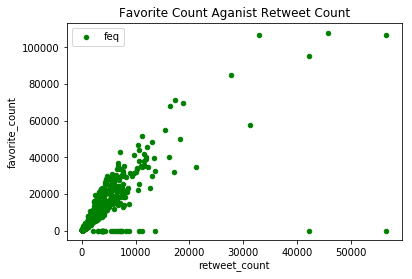

In [100]:
# Scatter Plot. 
df_master.plot(kind='scatter', y = 'favorite_count', x = 'retweet_count', color = 'Green', label = 'feq', title = 'Favorite Count Aganist Retweet Count')
plt.show()

In [101]:
df_master.dog_stage.value_counts()

pupper          76
doggo           24
puppo           13
doggo|pupper     5
floofer          4
Name: dog_stage, dtype: int64

In [102]:
# df_master['dog_stage'].plot(kind='bar', title='The Dog Stage Frequency')
# plt.xlabel('Dog Stage',fontsize=18)
# plt.ylabel('Frequency',fontsize=18)

In [103]:
df_master.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     917
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                      12
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      4
Name: source, dtype: int64

In [109]:
df_master[df_master['tweet_id'] == 879415818425184262]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
32,879415818425184262,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Duddles. He did an attempt. 13/10 some...,https://twitter.com/dog_rates/status/879415818...,13,10,Duddles,NaN,https://pbs.twimg.com/ext_tw_video_thumb/87941...,...,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,107956,45849


In [121]:
# df_master['retweet_count'].sort_values
df_master.sort_values(by=['favorite_count'])

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,jpg_url,...,p1_conf,p1_dog,prediction_algorithm_2,p2_conf,p2_dog,prediction_algorithm_3,p3_conf,p3_dog,favorite_count,retweet_count
274,794983741416415232,2016-11-05 19:24:28,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Rizzy. She smiles a lot...,https://twitter.com/dog_rates/status/789530877...,12,10,Rizzy,NaN,https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg,...,0.363272,True,kelpie,0.197021,True,Norwegian_elkhound,0.151024,True,0,3942
260,799774291445383169,2016-11-19 00:40:24,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Tucker. He would like a...,https://twitter.com/dog_rates/status/775085132...,13,10,Tucker,NaN,https://pbs.twimg.com/media/CsGnz64WYAEIDHJ.jpg,...,0.316565,True,golden_retriever,0.241929,True,Pomeranian,0.157524,True,0,5488
267,798644042770751489,2016-11-15 21:49:12,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Paull. He just stubbed ...,https://twitter.com/dog_rates/status/670444955...,10,10,Paull,NaN,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,...,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True,0,2153
268,798340744599797760,2016-11-15 01:44:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Davey. He'll have your ...,https://twitter.com/dog_rates/status/771770456...,11,10,Davey,NaN,https://pbs.twimg.com/media/CrXhIqBW8AA6Bse.jpg,...,0.533180,True,collie,0.192031,True,Border_collie,0.121626,True,0,3924
209,813944609378369540,2016-12-28 03:08:11,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bruce. He never backs d...,https://twitter.com/dog_rates/status/790277117...,11,10,Bruce,NaN,https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg,...,0.427742,True,Great_Dane,0.190503,True,curly-coated_retriever,0.146427,True,0,3732
112,842892208864923648,2017-03-18 00:15:37,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Stephan. He just wants ...,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,NaN,https://pbs.twimg.com/ext_tw_video_thumb/80710...,...,0.505370,True,Pomeranian,0.120358,True,toy_terrier,0.077008,True,0,56625
201,816014286006976512,2017-01-02 20:12:21,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Larry. He has no self c...,https://twitter.com/dog_rates/status/732005617...,11,10,Larry,NaN,https://pbs.twimg.com/media/CiibOMzUYAA9Mxz.jpg,...,0.677408,True,Border_collie,0.052724,True,cocker_spaniel,0.048572,True,0,6154
301,788070120937619456,2016-10-17 17:32:13,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bo and Ty. Bo eats pape...,https://twitter.com/dog_rates/status/761004547...,11,10,Bo,NaN,https://pbs.twimg.com/media/Co-hmcYXYAASkiG.jpg,...,0.735163,True,Sussex_spaniel,0.064897,True,Labrador_retriever,0.047704,True,0,3952
188,818588835076603904,2017-01-09 22:42:41,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Chelsea. She forgot how...,https://twitter.com/dog_rates/status/773547596...,11,10,Chelsea,pupper,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,...,0.372202,True,Chesapeake_Bay_retriever,0.137187,True,malamute,0.071436,True,0,7126
309,786036967502913536,2016-10-12 02:53:11,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Scout. He really wants ...,https://twitter.com/dog_rates/status/779834332...,11,10,Scout,NaN,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,...,0.993830,True,cocker_spaniel,0.003143,True,Great_Pyrenees,0.000917,True,0,8237
